In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
network = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")

In [ ]:
network.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

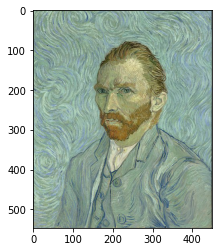

In [ ]:
style_image = tf.keras.preprocessing.image.load_img('vangogh.jpg')
content_image = tf.keras.preprocessing.image.load_img('tarsila_amaral.jpg')
plt.imshow(style_image)

In [ ]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)
content_image = content_image / 255
content_image = content_image[tf.newaxis, :]

style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape, content_image.shape

((1, 547, 450, 3), (1, 560, 600, 3))

In [ ]:
content_layers = ["block4_conv2"]
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

In [ ]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

    return network

In [ ]:
style_extractor = vgg_layers(style_layers)

In [ ]:
len(style_extractor.layers)

18

In [ ]:
style_outputs = style_extractor(style_image)
len(style_outputs)

5

In [ ]:
def gram_matrix(layer_activation):
    result = tf.linalg.einsum("bijc, bijd->bcd", layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name : value for content_name,
            value in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            style_name : value for style_name,
            value in zip(self.style_layers, style_outputs)
        }
        return {"content": content_dict, "style": style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
results = extractor(content_image)

In [ ]:
for key, value in results.items():
    print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [ ]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [ ]:
len(style_targets), len(content_targets)

(5, 1)

In [ ]:
new_image = tf.Variable(content_image)

In [ ]:
content_weight = 1
style_weight = 100

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

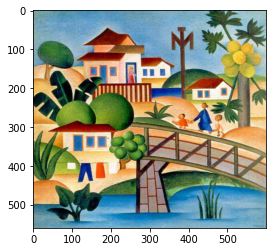

In [ ]:
plt.imshow(tf.squeeze(content_image, axis = 0))

In [ ]:
epochs = 3000
print_every = 5

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(new_image)

        content_outputs = outputs["content"]
        style_outputs = outputs["style"]

        content_loss = tf.add_n([
            tf.reduce_mean(
                (content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()
        ])
        style_loss = tf.add_n([
            tf.reduce_mean(
                (style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()
        ])

        total_loss = content_loss * content_weight  + style_loss * style_weight
    
    gradient = tape.gradient(total_loss, new_image)
    optimizer.apply_gradients([(gradient, new_image)])

    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch + 1) % print_every == 0:
        print("Epoch {} | content loss: {} | style loss: {} | total loss {}"
        .format(epoch + 1, content_loss, style_loss, total_loss))
        plt.imshow(tf.squeeze(new_image, axis = 0))
        plt.show()